# Modern Pandas (Part 2)

* see: https://github.com/TomAugspurger/effective-pandas
* see: https://tomaugspurger.github.io/method-chaining.html

In [114]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='ticks', context='talk')

# import prep

from functools import wraps
import logging

import statsmodels.api as sm

# Method Chaining

In [115]:
def read(fp):
    
    df = (pd.read_csv(fp)
                .rename(columns=str.lower)
                .drop('unnamed: 32', axis=1)
                .pipe(extract_city_name)
                .pipe(time_to_datetime, ['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time'])
                .assign(fl_date=lambda x: pd.to_datetime(x['fl_date']),
                             dest=lambda x: pd.Categorical(x['dest']),
                             origin=lambda x: pd.Categorical(x['origin']),
                             tail_num=lambda x: pd.Categorical(x['tail_num']),
                             unique_carrier=lambda x: pd.Categorical(x['unique_carrier']),
                             cancellation_code=lambda x: pd.Categorical(x['cancellation_code']))
    )
    
    return df

def extract_city_name(df):
    '''
    Chicago, IL -> Chicago for origin_city_name and dest_city_name
    '''
    
    cols = ['origin_city_name', 'dest_city_name']
    city = df[cols].apply(lambda x: x.str.extract("(.*), \w{2}", expand=False))
    _df = df.copy()
    _df[['origin_city_name', 'dest_city_name']] = city

    return _df

def time_to_datetime(df, columns):
    '''
    Combine all time items into datetimes.

    2014-01-01,0914 -> 2014-01-01 09:14:00
    '''
    
    _df = df.copy()
    
    def converter(col):
        timepart = col.astype(str).str.replace('\.0$', '').str.pad(4, fillchar='0') 
        return pd.to_datetime(df['fl_date'] + ' ' +
                               timepart.str.slice(0, 2) + ':' +
                               timepart.str.slice(2, 4),
                               errors='coerce')
        
    _df[columns] = _df[columns].apply(converter)
    
    return _df

In [119]:
%%time
output = 'data/flights.h5'

if not os.path.exists(output):
    df = read("data/756883233_T_ONTIME.csv")
    df.to_hdf(output, 'flights', format='table')
else:
    df = pd.read_hdf(output, 'flights', format='table')

CPU times: user 17.9 s, sys: 1.63 s, total: 19.5 s
Wall time: 20.7 s


In [120]:
df[['dep_time', 'arr_time', 'crs_arr_time', 'crs_dep_time']].head()

,dep_time,arr_time,crs_arr_time,crs_dep_time
0,2017-01-01 08:31:00,2017-01-01 12:09:00,2017-01-01 11:42:00,2017-01-01 08:00:00
1,2017-01-01 09:34:00,2017-01-01 18:09:00,2017-01-01 17:27:00,2017-01-01 09:00:00
2,2017-01-01 12:21:00,2017-01-01 20:40:00,2017-01-01 19:58:00,2017-01-01 11:30:00
3,2017-01-01 12:52:00,2017-01-01 17:49:00,2017-01-01 16:12:00,2017-01-01 11:35:00
4,2017-01-01 18:55:00,2017-01-01 06:42:00,2017-01-01 06:00:00,2017-01-01 18:55:00


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450017 entries, 0 to 450016
Data columns (total 32 columns):
fl_date                  450017 non-null datetime64[ns]
unique_carrier           450017 non-null category
airline_id               450017 non-null int64
tail_num                 449378 non-null category
fl_num                   450017 non-null int64
origin_airport_id        450017 non-null int64
origin_airport_seq_id    450017 non-null int64
origin_city_market_id    450017 non-null int64
origin                   450017 non-null category
origin_city_name         450017 non-null object
dest_airport_id          450017 non-null int64
dest_airport_seq_id      450017 non-null int64
dest_city_market_id      450017 non-null int64
dest                     450017 non-null category
dest_city_name           450017 non-null object
crs_dep_time             450017 non-null datetime64[ns]
dep_time                 441445 non-null datetime64[ns]
dep_delay                441476 non-null float64


# Costs

In [138]:
def log_shape(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print("{}, {}".format(func.__name__, result.shape))
        return result
    return wrapper

def log_dtypes(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        result = func(*args, **kwargs)
        print("{}, {}".format(func.__name__, result.dtypes))
        return result
    return wrapper

@log_shape
@log_dtypes
def load(fp):
    df = pd.read_csv(fp, index_col=0, parse_dates=True)
    return df

@log_shape
@log_dtypes
def update_events(df, new_events):
    df.loc[new_events.index, 'foo'] = new_events
    return df

In [139]:
_df = load("data/756883233_T_ONTIME.csv")

load, UNIQUE_CARRIER            object
AIRLINE_ID                 int64
TAIL_NUM                  object
FL_NUM                     int64
ORIGIN_AIRPORT_ID          int64
ORIGIN_AIRPORT_SEQ_ID      int64
ORIGIN_CITY_MARKET_ID      int64
ORIGIN                    object
ORIGIN_CITY_NAME          object
DEST_AIRPORT_ID            int64
DEST_AIRPORT_SEQ_ID        int64
DEST_CITY_MARKET_ID        int64
DEST                      object
DEST_CITY_NAME            object
CRS_DEP_TIME               int64
DEP_TIME                 float64
DEP_DELAY                float64
TAXI_OUT                 float64
WHEELS_OFF               float64
WHEELS_ON                float64
TAXI_IN                  float64
CRS_ARR_TIME               int64
ARR_TIME                 float64
ARR_DELAY                float64
CANCELLED                float64
CANCELLATION_CODE         object
CARRIER_DELAY            float64
WEATHER_DELAY            float64
NAS_DELAY                float64
SECURITY_DELAY           float64
LATE

In [125]:
_df.head()

,UNIQUE_CARRIER,AIRLINE_ID,TAIL_NUM,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,...,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32
FL_DATE,,,,,,,,,,,,,,,,,,,,,
2017-01-01,AA,19805,N787AA,1,12478,1247803,31703,JFK,"New York, NY",12892,...,1209.0,27.0,0.0,NaN,27.0,0.0,0.0,0.0,0.0,NaN
2017-01-01,AA,19805,N783AA,2,12892,1289204,32575,LAX,"Los Angeles, CA",12478,...,1809.0,42.0,0.0,NaN,34.0,0.0,8.0,0.0,0.0,NaN
2017-01-01,AA,19805,N791AA,4,12892,1289204,32575,LAX,"Los Angeles, CA",12478,...,2040.0,42.0,0.0,NaN,7.0,0.0,0.0,0.0,35.0,NaN
2017-01-01,AA,19805,N391AA,5,11298,1129804,30194,DFW,"Dallas/Fort Worth, TX",12173,...,1749.0,97.0,0.0,NaN,77.0,0.0,20.0,0.0,0.0,NaN
2017-01-01,AA,19805,N346AA,6,13830,1383002,33830,OGG,"Kahului, HI",11298,...,642.0,42.0,0.0,NaN,0.0,0.0,42.0,0.0,0.0,NaN


# Application

In [165]:
help(pd.TimeGrouper)

Help on class TimeGrouper in module pandas.core.api:

class TimeGrouper(builtins.object)
 |  # Deprecation: xref gh-16747
 |  
 |  Static methods defined here:
 |  
 |  __new__(cls, *args, **kwargs)
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/ml_env/lib/python3.6/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


<Figure size 864x432 with 0 Axes>

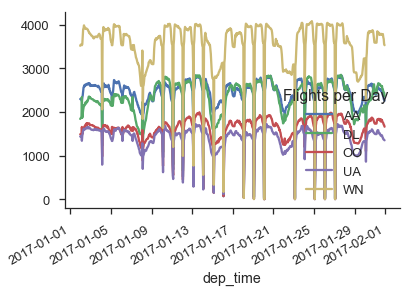

In [178]:
(df.dropna(subset=['dep_time', 'unique_carrier'])
     .loc[df['unique_carrier'].isin(df['unique_carrier'].value_counts().index[:5])]
     .set_index('dep_time')
     .groupby(['unique_carrier', pd.TimeGrouper("H")])['fl_num']
     .count()
     .unstack(0)
     .fillna(0)
     .rolling(24)
     .sum()
     .rename_axis("Flights per Day", axis=1)
     .plot()
)
sns.despine()

/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/ml_env/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


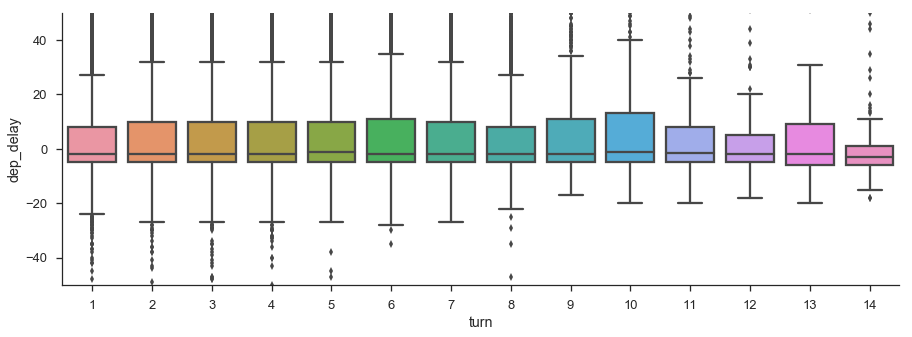

In [189]:
# %config InlineBackend.figure_format = 'png'
flights = (df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
           .dropna()
           .sort_values('dep_time')
           .loc[lambda x: x.dep_delay < 500]
           .assign(turn = lambda x:
                x.groupby(['fl_date', 'tail_num'])
                 .dep_time
                 .transform('rank').astype(int)))

fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(x='turn', y='dep_delay', data=flights, ax=ax)
ax.set_ylim(-50, 50)
sns.despine()

/Users/yuki/.pyenv/versions/miniconda3-4.1.11/envs/ml_env/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


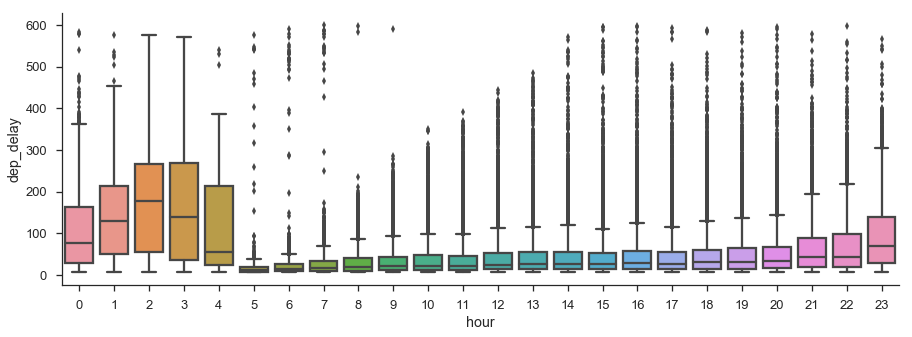

In [190]:
plt.figure(figsize=(15, 5))
(df[['fl_date', 'tail_num', 'dep_time', 'dep_delay']]
    .dropna()
    .assign(hour=lambda x: x.dep_time.dt.hour)
    .query('5 < dep_delay < 600')
    .pipe((sns.boxplot, 'data'), 'hour', 'dep_delay'))
sns.despine()